ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


The next valid order id is:  27
AccountSummary. ReqId: 9001 Account: U11359296 Tag:  BuyingPower Value: 105744.75 Currency: USD
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: -10 Avg cost: 414.2065405
HistoricalDataEnd. ReqId: 1 from 20231026 11:26:22 US/Eastern to 20231027 11:26:22 US/Eastern
openOrder id: 27 SPY STK @ SMART : BUY MKT 10 PreSubmitted
orderStatus - orderid: 27 status: PreSubmitted filled 0 remaining 10 lastFillPrice 0.0
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: -10 Avg cost: 414.2065405
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: -9 Avg cost: 414.2065405
Order Executed:  -1 SPY STK USD 000154a9.653bbb17.01.01 27 1 2
openOrder id: 27 SPY STK @ SMART : BUY MKT 10 PreSubmitted
orderStatus - orderid: 27 status: PreSubmitted filled 1 remaining 9 lastFillPrice 414.16
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 0 Avg cost: 0
Order Executed:  -

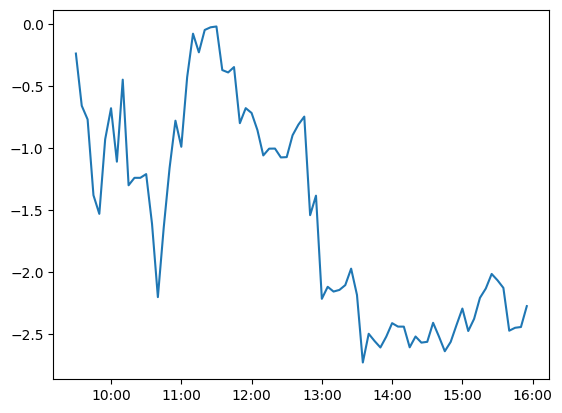

0
213.899887
AccountSummary. ReqId: 9001 Account: U11359296 Tag:  BuyingPower Value: 110716.52 Currency: USD


In [1]:
from modelClasses import BasicModel, BatchClipEarlyStopD
from analyzerClasses import BasicAnalyzer, CrossoverAnalyzer, CrossoverAnalyzerUpdated
import tableGetter
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf
from time import sleep
from datetime import datetime, date, timedelta, time
from sklearn.preprocessing import MinMaxScaler
import threading
from decimal import *

df = tableGetter.SpyHistory()
currentModel = BasicModel(df)
currentAnalyzer = BasicAnalyzer()

while True:    
    if datetime.today().time() > time(10) and datetime.today().time() < time(14, 30):

        class IBapi(EWrapper, EClient):
            def __init__(self):
                EClient.__init__(self, self)
                self.data = []
                self.df=None
                self.currentPosition  = 0
                self.buyingPower = 0.0

            def historicalData(self, reqId, bar):
                self.data.append([bar.date, bar.open, bar.close])

            def historicalDataUpdate(self, reqId, bar):
                newData = pd.DataFrame([[bar.date, bar.open, bar.close]], columns=['DateTime', 'Open', 'Close'])
                newData['DateTime'] = pd.to_datetime(newData['DateTime'],unit='s').dt.tz_localize(tz='UTC')
                newData['DateTime'] = newData['DateTime'].dt.tz_convert(tz='US/Eastern')
                newData['date'] = [d.date() for d in newData['DateTime']]
                newData['time'] = [d.time() for d in newData['DateTime']]
                newData['Open'] = newData['Open'].astype(float)
                newData['Close'] = newData['Close'].astype(float)
                newData['Difference'] = newData['Close'] - newData['Open']
                if (self.df['DateTime'] == newData['DateTime'][0]).any():
                    self.df.loc[self.df['DateTime'] == newData['DateTime'][0]] = newData['DateTime'][0],newData['Open'][0],newData['Close'][0],newData['date'][0],newData['time'][0],newData['Difference'][0]
                else:
                    self.df.loc[newData['DateTime'][0]] = newData['DateTime'][0],newData['Open'][0],newData['Close'][0],newData['date'][0],newData['time'][0],newData['Difference'][0]
                
                
            def historicalDataEnd(self, reqId: int, start: str, end: str):
                print("HistoricalDataEnd. ReqId:", reqId, "from", start, "to", end)
                self.df = pd.DataFrame(self.data, columns=['DateTime', 'Open', 'Close'])
                self.df['DateTime'] = pd.to_datetime(self.df['DateTime'],unit='s').dt.tz_localize(tz='UTC')
                self.df['DateTime'] = self.df['DateTime'].dt.tz_convert(tz='US/Eastern')
                self.df['Open'] = self.df['Open'].astype(float)
                self.df['Close'] = self.df['Close'].astype(float)
                self.df['date'] = [d.date() for d in self.df['DateTime']]
                self.df['time'] = [d.time() for d in self.df['DateTime']]
                self.df['Difference'] = self.df['Close'] - self.df['Open']

            def nextValidId(self, orderId: int):
                super().nextValidId(orderId)
                self.nextorderId = orderId
                print('The next valid order id is: ', self.nextorderId)

            def orderStatus(self, orderId, status, filled, remaining, avgFullPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
                print('orderStatus - orderid:', orderId, 'status:', status, 'filled', filled, 'remaining', remaining, 'lastFillPrice', lastFillPrice)
            
            def openOrder(self, orderId, contract, order, orderState):
                print('openOrder id:', orderId, contract.symbol, contract.secType, '@', contract.exchange, ':', order.action, order.orderType, order.totalQuantity, orderState.status)

            def execDetails(self, reqId, contract, execution):
                print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId, execution.orderId, execution.shares, execution.lastLiquidity)
        
            def position(self, account: str, contract: Contract, position: Decimal, avgCost: float):
                super().position(account, contract, position, avgCost)
                print("Position.", "Account:", account, "Symbol:", contract.symbol, "SecType:", contract.secType, "Currency:", contract.currency,"Position:", decimalMaxString(position), "Avg cost:", floatMaxString(avgCost))
                self.currentPosition = int(position)

            def accountSummary(self, reqId: int, account: str, tag: str, value: str, currency: str):
                super().accountSummary(reqId, account, tag, value, currency)
                print("AccountSummary. ReqId:", reqId, "Account:", account,"Tag: ", tag, "Value:", value, "Currency:", currency)
                self.buyingPower = float(value)
                
                
        def run_loop():
            app.run()

        app = IBapi()
        app.connect('127.0.0.1', 7496, 125)

        #Start the socket in a thread
        api_thread = threading.Thread(target=run_loop, daemon=True)
        api_thread.start()

        sleep(1) #Sleep interval to allow time for connection to server

        #Create contract object
        contract = Contract()
        contract.symbol = 'SPY'
        contract.secType = 'STK'
        contract.exchange = 'SMART'
        contract.currency = 'USD'
                
        #Create order object
        buyOrder = Order()
        buyOrder.action = 'BUY'
        buyOrder.totalQuantity = 100
        buyOrder.orderType = 'MKT'

        sellOrder = Order()
        sellOrder.action = 'SELL'
        sellOrder.totalQuantity = 100
        sellOrder.orderType = 'MKT'
        
        #Request historical candles
        app.reqHistoricalData(1, contract, '', '1 D', '5 mins', 'TRADES', 1, 2, True, [])
        app.reqPositions()

        sleep(5)

        if app.currentPosition > 0:
            sellOrder.totalQuantity = abs(app.currentPosition)
            app.placeOrder(app.nextorderId, contract, sellOrder)
            app.nextorderId += 1
        if app.currentPosition < 0:
            buyOrder.totalQuantity = abs(app.currentPosition)
            app.placeOrder(app.nextorderId, contract, buyOrder)
            app.nextorderId += 1

        app.reqAccountSummary(9001, "All", "BuyingPower")
        sleep(2)
        totalBuyingPower = app.buyingPower

        while datetime.today().time() > time(10) and datetime.today().time() < time(14, 30): 
            app.reqPositions()
            
            currentTick = app.df.iloc[-1]
            todaysData = app.df[:-1]
            todaysData = todaysData.loc[todaysData['time'].isin(df.time.unique())]
            loadedModel = tf.keras.models.load_model('model_'+str(todaysData.iloc[-1]['time']).replace(':','_')+'.keras')
                        
            X = np.array(currentModel.inputScalar.transform(todaysData[currentModel.inputs]))
            input_sequence = X.reshape(1, len(todaysData), currentModel.numInput)
            predicted_sequence = currentModel.outputScalar.inverse_transform(pd.DataFrame(loadedModel.predict(input_sequence)[0], columns=['Difference']))
            
            actionTaken = currentAnalyzer.action(predicted_sequence,todaysData)

            if actionTaken != '':
                if currentAnalyzer.closed:
                    if actionTaken == 'GOLONG':
                        buyOrder.totalQuantity = abs(app.currentPosition) + int((totalBuyingPower / 2) / currentTick['Close']) - 1
                        app.placeOrder(app.nextorderId, contract, buyOrder)
                        app.nextorderId += 1
                    if actionTaken == 'GOSHORT':
                        sellOrder.totalQuantity = abs(app.currentPosition) + int((totalBuyingPower / 2) / currentTick['Close']) - 1
                        app.placeOrder(app.nextorderId, contract, sellOrder)
                        app.nextorderId += 1
                    if actionTaken == 'BUY':
                        buyOrder.totalQuantity = abs(app.currentPosition)
                        app.placeOrder(app.nextorderId, contract, buyOrder)
                        app.nextorderId += 1
                    if actionTaken == 'SELL':
                        sellOrder.totalQuantity = abs(app.currentPosition)
                        app.placeOrder(app.nextorderId, contract, sellOrder)
                        app.nextorderId += 1
                else:
                    if actionTaken == 'GOLONG':
                        buyOrder.totalQuantity = int((totalBuyingPower / 2) / currentTick['Close']) - 1
                        app.placeOrder(app.nextorderId, contract, buyOrder)
                        app.nextorderId += 1
                    if actionTaken == 'GOSHORT':
                        sellOrder.totalQuantity = int((totalBuyingPower / 2) / currentTick['Close']) - 1
                        app.placeOrder(app.nextorderId, contract, sellOrder)
                        app.nextorderId += 1
            

            dfTotal = pd.DataFrame(columns=['Total','Time'])
            Total = 0
            count = 0
            for currentTime in df.time.unique():
                if(todaysData.loc[todaysData['time']==currentTime].empty is False):
                    Total = Total + todaysData.loc[todaysData['time']==currentTime]['Difference'].values[0]
                else:
                    Total = Total + predicted_sequence[count]
                    count = count + 1
                dfTotal.loc[len(dfTotal.index)] = [Total,currentTime] 
            datetimes = [datetime.combine(date.today(), t) for t in dfTotal["Time"]]
            xformatter = mdates.DateFormatter('%H:%M')
            plt.plot(datetimes, dfTotal["Total"], label = "curve 1")
            plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
            plt.show()
            print(currentAnalyzer.totalWin)

            nextUpdate = datetime(datetime.today().year, datetime.today().month, datetime.today().day, currentTick['time'].hour, currentTick['time'].minute) + timedelta(minutes=5,seconds=2)
            timeToWait = (nextUpdate - datetime.today()).total_seconds()
            print(timeToWait)
            if timeToWait > 0:
                sleep(timeToWait)

        if app.currentPosition > 0:
            sellOrder.totalQuantity = abs(app.currentPosition)
            app.placeOrder(app.nextorderId, contract, sellOrder)
            app.nextorderId += 1
        if app.currentPosition < 0:
            buyOrder.totalQuantity = abs(app.currentPosition)
            app.placeOrder(app.nextorderId, contract, buyOrder)
            app.nextorderId += 1

        app.disconnect()

    else:
        # totalWin =  totalWin + abs(lastPrice  - todaysData.iloc[-1]['Close'])
        sleep(5)


In [3]:
app.currentPosition